In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_excel("C:\\Users\\prince\\OneDrive\\Desktop\\Pharmaceutical Supply Chain Optimization.xlsx")
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Drug                 100000 non-null  object
 1   Demand_Forecast      100000 non-null  int64 
 2   Optimal_Stock_Level  100000 non-null  int64 
 3   Restocking_Strategy  100000 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


,Demand_Forecast,Optimal_Stock_Level
count,100000.000000,100000.000000
mean,5489.372180,6270.155320
std,2597.544993,2744.393068
min,1000.000000,1500.000000
25%,3243.000000,3899.750000
50%,5487.000000,6278.000000
75%,7738.000000,8660.000000
max,9999.000000,10999.000000


In [3]:

print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


Drug                   0
Demand_Forecast        0
Optimal_Stock_Level    0
Restocking_Strategy    0
dtype: int64
Duplicates: 5


In [4]:
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


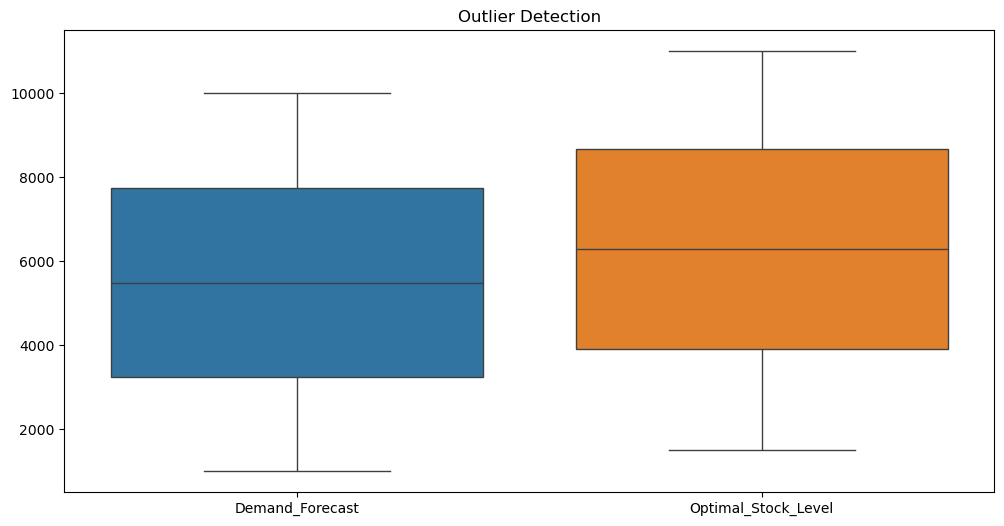

In [5]:

plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.title("Outlier Detection")
plt.show()
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]


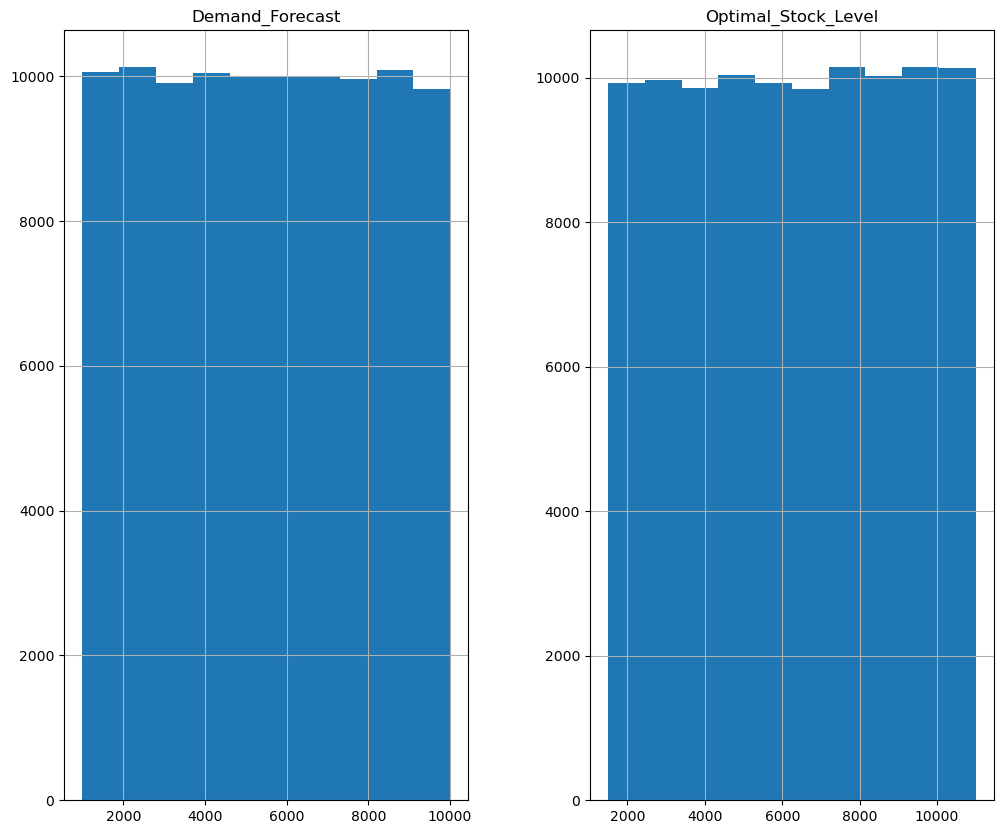

In [6]:
df.hist(figsize=(12,10))
plt.show()


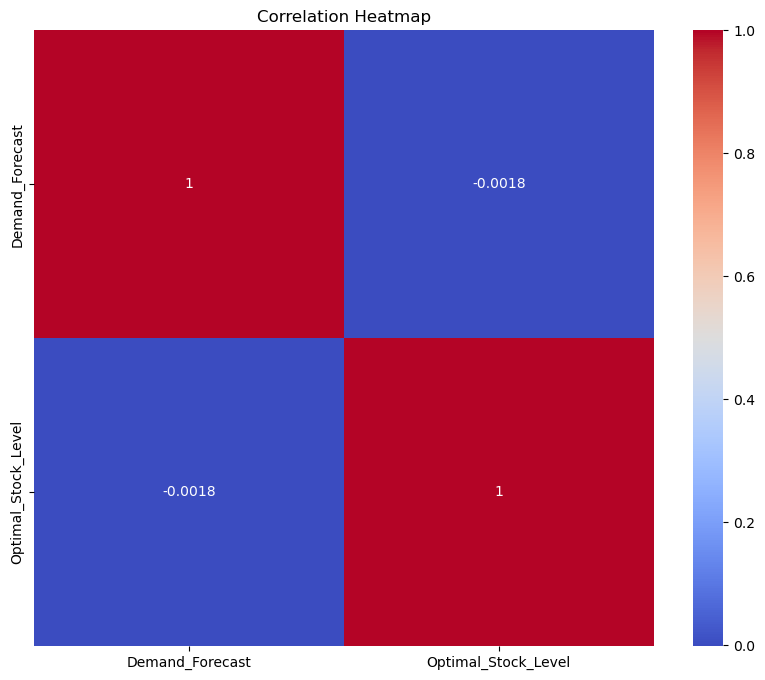

In [7]:
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap")
plt.show()



In [8]:

if 'Dosage' in df.columns and 'Volume' in df.columns:
    df['Dosage_to_Volume'] = df['Dosage'] / df['Volume']


In [9]:
if 'Temperature' in df.columns:
    df['Temp_Band'] = pd.cut(df['Temperature'],
                             bins=[0,10,20,30,50],
                             labels=['Low','Medium','High','Very High'])


In [10]:
le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [11]:
target = "Optimal_Stock_Level" 
X = df.drop(target,axis=1)
y = df[target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)


Linear Regression RMSE: 2740.5481472610077
Linear Regression R2: -0.00014543775784248147


In [15]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)


Random Forest RMSE: 3156.4192922598004
Random Forest R2: -0.3267150746851355


In [16]:
gb = GradientBoostingRegressor(random_state=42)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting RMSE:", rmse_gb)
print("Gradient Boosting R2:", r2_gb)


Gradient Boosting RMSE: 2741.400515546048
Gradient Boosting R2: -0.0007676671640008959


In [17]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb],
    "R2 Score": [r2_lr, r2_rf, r2_gb]
})

print(results)


               Model         RMSE  R2 Score
0  Linear Regression  2740.548147 -0.000145
1      Random Forest  3156.419292 -0.326715
2  Gradient Boosting  2741.400516 -0.000768


In [18]:
model = RandomForestRegressor(random_state=42)


In [19]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [20]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)


In [21]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [22]:
print("\nBest Parameters:")
print(grid_search.best_params_)

print("\nBest Score (Negative RMSE):")
print(grid_search.best_score_)


Best Parameters:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Best Score (Negative RMSE):
-2745.661907507999


In [23]:

best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nFinal Model RMSE:")
print(rmse)
cv_scores = cross_val_score(
    best_model,
    X,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

cv_scores = -cv_scores

print("\nCross Validation RMSE scores:")
print(cv_scores)

print("\nAverage CV RMSE:")
print(cv_scores.mean())



Final Model RMSE:
2740.828775166074

Cross Validation RMSE scores:
[2737.43675323 2740.90525079 2749.10063908 2743.28503334 2752.67632457]

Average CV RMSE:
2744.680800203171
